## MultiLayered Perceptron (MLP) in PyTroch

In this notebook we will develop an MLP model to classify a tabular dataset. 

**About the dataset**

- Diabetes Clinical dataset
- 100,000 records
- Dataset Location: https://www.kaggle.com/datasets/priyamchoksi/100000-diabetes-clinical-dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
data = pd.read_csv("./diabetes_dataset.csv")

In [3]:
data.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

In [5]:
data['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [6]:
data['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [7]:
data["gender"] = data["gender"].map({"Female": 0, "Male": 1, "Other": 2})
data["smoking_history"] = data["smoking_history"].map({"No Info": 0, "never": 1, "former": 2, "current": 3, "not current": 4, "ever": 5})
data = data.drop(["year", "location"], axis=1)
data.head()

,gender,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,0,32.0,0,0,0,0,1,0,0,1,27.32,5.0,100,0
1,0,29.0,0,1,0,0,0,0,0,1,19.95,5.0,90,0
2,1,18.0,0,0,0,0,1,0,0,1,23.76,4.8,160,0
3,1,41.0,0,0,1,0,0,0,0,1,27.32,4.0,159,0
4,0,52.0,1,0,0,0,0,0,0,1,23.75,6.5,90,0


In [8]:
data.shape

(100000, 14)

In [9]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.15, random_state=579, stratify=data['diabetes'])

train_data, validation_data = train_test_split(train_data, test_size=0.1, random_state=123, stratify=train_data['diabetes'])

train_data.shape, validation_data.shape, test_data.shape

((76500, 14), (8500, 14), (15000, 14))

In [10]:
RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 25
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(DEVICE)

cuda


In [11]:
class PandasDataset(Dataset):
    def __init__(self, data, target_column):
        self.X = data.drop(columns=[target_column]).values
        self.y = data[target_column].values

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

In [12]:
train_dataset = PandasDataset(train_data, target_column="diabetes")
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = PandasDataset(validation_data, target_column="diabetes")
validation_data_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = PandasDataset(test_data, target_column="diabetes")
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
class MLP(nn.Module):

    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.ReLU(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, num_classes)
        )

    def forward(self, x):

        logits = self.network(x)

        return logits

In [14]:
number_of_features = data.shape[1]-1
number_of_classes = 2

print(f"number of features: {number_of_features}, number of classes: {number_of_classes}")

number of features: 13, number of classes: 2


In [15]:
model = MLP(input_size=number_of_features, hidden_size_1=40, hidden_size_2=40, num_classes=number_of_classes)
model = model.to(DEVICE)
print(model)

MLP(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=2, bias=True)
  )
)


How many number of parameters does this model have?

In [16]:
total_params = sum(p.numel() for p in model.parameters())

print(total_params)

2282


In [17]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
def compute_loss(net, data_loader):
    net.eval() # evaluation mode
    total_loss, total_samples = 0.0, 0
    with torch.no_grad(): # no gradient tracking
        for features, targets in data_loader:
            features, targets = features.to(DEVICE), targets.to(DEVICE)
            logits = net(features)
            loss = F.cross_entropy(logits, targets, reduction="sum")  # sum, not mean
            total_loss += loss.item()
            total_samples += targets.size(0)
    return total_loss / total_samples


def compute_accuracy(net, data_loader):
    net.eval()  # evaluation mode
    correct_pred, num_examples = 0, 0
    with torch.no_grad():  # no gradient tracking
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            logits = net(features)
            predicted_labels = torch.argmax(logits, dim=1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().item()

    return correct_pred / num_examples * 100

In [19]:
training_loss = []
validation_loss = []

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    
    for batch_idx, (features, labels) in enumerate(train_data_loader):

        features = features.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        

    # training loss
    loss_train = compute_loss(model, train_data_loader)
    training_loss.append(loss_train)

    # validation loss
    loss_val = compute_loss(model, validation_data_loader)
    validation_loss.append(loss_val)

    # training accuracy for each epoch
    training_accuracy = compute_accuracy(model, train_data_loader)

    # validation accuracy for each epoch
    validation_accuracy = compute_accuracy(model, validation_data_loader)

    print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | Train Loss: {loss_train:.4f} | Validation Loss: {loss_val:.4f} | \
           Train Acc: {training_accuracy:.2f}% | Validation Acc: {validation_accuracy:.2f}%")
    
print(f"Total Time Elapsed: {((time.time() - start_time)/60):.2f} min")


Epoch: 001/025 | Train Loss: 0.2839 | Validation Loss: 0.2872 |            Train Acc: 91.56% | Validation Acc: 91.55%
Epoch: 002/025 | Train Loss: 0.2922 | Validation Loss: 0.2901 |            Train Acc: 91.68% | Validation Acc: 91.55%
Epoch: 003/025 | Train Loss: 0.2529 | Validation Loss: 0.2553 |            Train Acc: 92.59% | Validation Acc: 92.34%
Epoch: 004/025 | Train Loss: 0.2475 | Validation Loss: 0.2508 |            Train Acc: 92.65% | Validation Acc: 92.48%
Epoch: 005/025 | Train Loss: 0.2397 | Validation Loss: 0.2427 |            Train Acc: 92.74% | Validation Acc: 92.52%
Epoch: 006/025 | Train Loss: 0.2393 | Validation Loss: 0.2408 |            Train Acc: 92.63% | Validation Acc: 92.41%
Epoch: 007/025 | Train Loss: 0.2308 | Validation Loss: 0.2332 |            Train Acc: 92.88% | Validation Acc: 92.71%
Epoch: 008/025 | Train Loss: 0.2263 | Validation Loss: 0.2298 |            Train Acc: 92.69% | Validation Acc: 92.45%
Epoch: 009/025 | Train Loss: 0.2169 | Validation Loss: 0

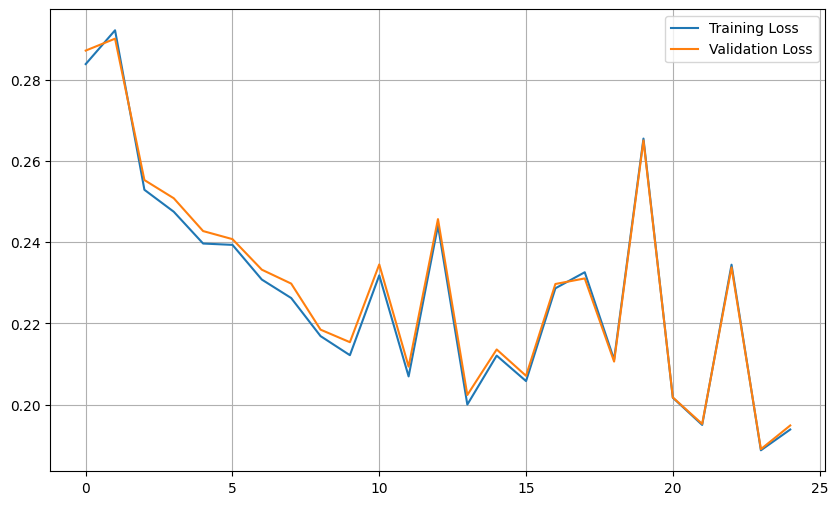

In [20]:
plt.figure(figsize=(10,6))
plt.plot(range(NUM_EPOCHS), training_loss, label="Training Loss")
plt.plot(range(NUM_EPOCHS), validation_loss, label="Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [21]:
# compute test accuracy after completeing the training
test_accuracy = compute_accuracy(model, test_data_loader)

print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 93.32%
